<a href="https://colab.research.google.com/github/LeonardoGoncRibeiro/PersonalProjects/blob/main/CustomerSegmentation/CustomerSegmentation_OLIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer segmentation: using data from OLIST

In this project, I will perform customer segmentation based on data from e-commerce provided by the brazilian company OLIST. This data can be found on Kaggle:

https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?resource=download

Here, we will perform segmentation using unsupervised learning methods (clustering). Also, we will try to use a RFM analysis, where our customers will be divided in groups based on their:

* Recency: How long has it been since they last bought in our e-commerce?
* Frequency: How many times have they bought in our e-commerce?
* Monetary: How much have them spent in our e-commerce?

First, let's import the necessary packages:



In [49]:
import pandas as pd                             # Data manipulation
import numpy as np                              # Array manipulation

import matplotlib.pyplot as plt                 # Data visualization
import seaborn as sns                           # Data visualization

import datetime                                 # Manipulation of date format

# Modeling

from sklearn.cluster import KMeans              # KMeans algorithm for clustering data

## Data collection

The data we will be using was submitted to Kaggle by OLIST, and contains information about different orders, customers and sellers. Since we will perform an RFM analysis of our customers, we only need information about the customers, the day of their orders, and the value of each order. Thus, let's get this information:

In [50]:
orders   = pd.read_csv('olist_orders_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')

Let's see those dataframes:

In [51]:
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [52]:
payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


Both dataframes bring information about orders. For a given order_id, the first one defines the customer, the order_status, and when the order was made. The second brings information about the order value, payments installments, and payment type. 

# Data cleaning

So, let's look a little closer at our data sets. First, the orders dataset. Let's check its size, and if it has any null value:

In [53]:
print(f"Number of orders: {orders.shape[0]}")

Number of orders: 99441


In [54]:
orders.isnull( ).sum( )

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

So, we have some null values in the columns which state the day of the order approval and delivers. Well, if the order was never delivered, these columns can, indeed, be null. Let's check the order_status column:

In [55]:
orders.order_status.unique( )

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Note that there are multiple order status. For instance, for canceled or invoiced orders, it is expected that we have no deliver date. Let's update our dataframe, keeping only the orders that were delivered:

In [56]:
orders = orders.query("order_status == 'delivered'")

Now, let's check again the number of orders, and if it has any null values:

In [57]:
print(f"Number of orders: {orders.shape[0]}")

Number of orders: 96478


In [58]:
orders.isnull( ).sum( )

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

We did lost some entries, but not much. Also, it seems that we still have some null values, even when filtering for the delivered orders. However, note that these columns with null values will not be used for our RFM analysis. So, let's drop the unimportant columns:

In [59]:
orders = orders[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]

Nice! Now, let's see if we have any duplicated entry:

In [60]:
orders.duplicated( ).sum( )

0

Great! No duplicated entry. 

Now, let's look at the payments dataframe. First, let's see the number of entries and if there is any null entry:

In [61]:
print(f"Number of payments: {payments.shape[0]}")

Number of payments: 103886


In [62]:
payments.isnull( ).sum( )

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

Here, we have 103886 payments, and no null values. Great! Once again, let's get only the information we really need:

In [63]:
payments = payments[['order_id', 'payment_sequential', 'payment_value']]

Now, let's look for duplicated entries:

In [64]:
payments.duplicated( ).sum( )

0

Nice! Note that the 'payment_sequential' column serves to collect data for sequential payments, when, for the same order, one wishes to perform multiple payments. Let's actually drop this feature, and get the sum of the value for the same order:

In [65]:
order_payments = payments.groupby('order_id')

payments = order_payments.sum( )['payment_value'].to_frame( ).reset_index( )

payments.head( )

,order_id,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04


Great! Again, let's check if we have any duplicated entry:

In [66]:
payments.duplicated( ).sum( )

0

Finally, let's see the number of entries we ended up with:

In [67]:
print(f"Number of payments: {payments.shape[0]}")

Number of payments: 99440


So, here, we have 99440 entries, which is almost the same as the number of entries in the first orders dataframe (99441). The difference here might be due to an error when collecting data, which is understandable. Finally, let's merge these two dataframes:

In [68]:
df = orders.merge(payments, how = 'left', left_on = 'order_id', right_on = 'order_id')
df.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,38.71
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,141.46
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,179.12
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,72.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,28.62


Nice! It seems to have worked. Finally, let's, once again, look at the number of entries and if we have any missing value or duplicated entries. Here, we will use the info( ) method:

In [69]:
df.info( )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 96477
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96478 non-null  object 
 1   customer_id               96478 non-null  object 
 2   order_status              96478 non-null  object 
 3   order_purchase_timestamp  96478 non-null  object 
 4   payment_value             96477 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.4+ MB


In [70]:
df.duplicated( ).sum( )

0

Actually, we have a missing value in the payment_value column. Let's simply drop this value, which is probably related to that missing order that was not in the payments dataframe:

In [71]:
df.dropna(inplace = True)

Nice! Note that the info( ) method also has information about the type of each column. The order_purchase_timestamp is of type object, even though it should be of type datetime. Thus, let's fix this:

In [72]:
df.order_purchase_timestamp = pd.to_datetime(df.order_purchase_timestamp)



Finally, let's start performing the RFM analysis. So, for RFM, we need to find indicators for Recency, Frequency, and Monetary. Then, we need to cluster al customers in each indicator. Finally, we will be able to determine which type of customer we are dealing with, and what is the best approach to tackle them. 

# Recency

First, we will start with recency. For recency, we will get how many days it has passed since the customers last bought. Since our dataset is not from today, we will first get the maximum order date in our dataset:

In [73]:
max_day = df.order_purchase_timestamp.max( )
max_day

Timestamp('2018-08-29 15:00:37')

So, the maximum order date is 2018-8-29. Now, let's build our recency indicator:

In [74]:
group_by_customer = df.groupby('customer_id')                 # Grouping by customers
df_recency        = group_by_customer.max( )['order_purchase_timestamp'].reset_index( )

In [75]:
df_recency['Recency'] = (max_day - df_recency.order_purchase_timestamp).dt.days

Now, let's take a look at our indicator. Let's use describe( ) to understand how our values for recency are distributed:

In [76]:
df_recency.Recency.describe( )

count    96477.000000
mean       239.116453
std        152.830149
min          0.000000
25%        115.000000
50%        220.000000
75%        349.000000
max        695.000000
Name: Recency, dtype: float64

So, on average, our customers have passed 239 days without buying in our e-commerce. Let's plot a histogram to get a better sense of the distribution of our data:

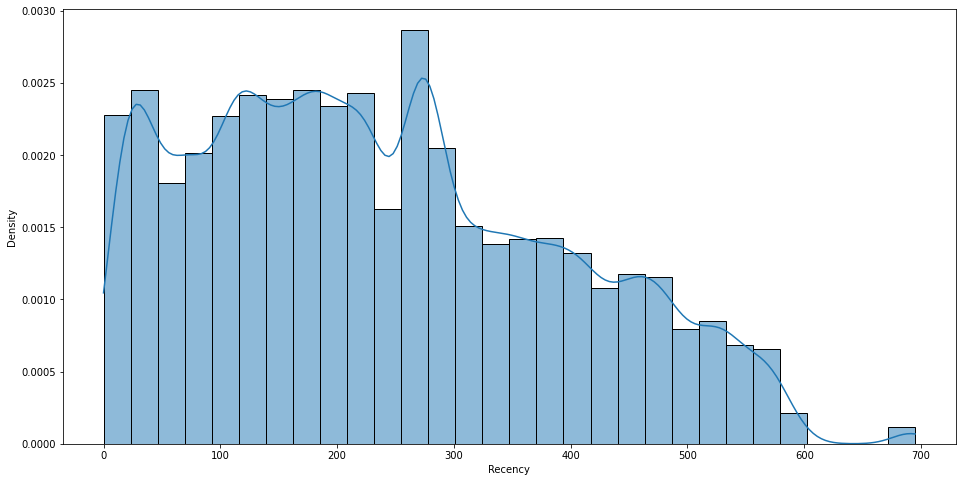

In [77]:
plt.figure(figsize = (16, 8))

sns.histplot(df_recency.Recency, stat = 'density', kde = True, bins = 30)

So, we have a higher concentration in the left side. Very few people have spent more than 2 years without buying in our e-commerce again.

Now, before we jump to the next topic, let's get a new dataframe with data for recency:

In [78]:
df_tmp = df_recency.Recency.copy( ).to_frame( )

## Clustering recency

So, to cluster our data, we will use a $k$-means algorithm. First, to get the number of clusters, we will use the elbow rule. 

https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,number%20of%20clusters%20to%20use.

So, let's test 10 different $K$, and evaluate the WCSS (Within-Cluster Sum of Squares). First, we will define a function to get the WCSS:

In [79]:
def calc_wcss(data, k_init, k_end):
  wcss = []
  for k in range(k_init, k_end + 1):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X = data)
    wcss.append(kmeans.inertia_)
  return wcss

Now, let's evaluate the WCSS for $K$ from 1 to 10:

In [80]:
sum_squares = calc_wcss(df_tmp.values, 1, 10)

Now, let's plot the WCSS:

Text(0.5, 0, '$K$')

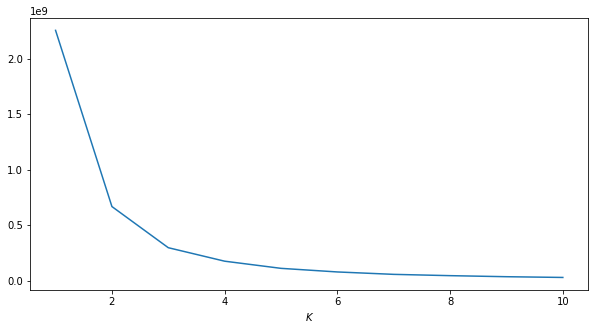

In [81]:
plt.figure(figsize = (10, 5))
plt.plot(range(1, 11), sum_squares)

plt.xlabel('$K$')

By the elbow rule, the best point seems to be $K = 3$. However, we can get a better sense by using a mathematical formula:

\begin{equation}
d(a_1, a_n, a_i) = \dfrac{|(y_n - y_1) \, x_i - (x_n - x_1) \, y_i + x_n \, y_1 + y_n \, x_1|}{\sqrt{(y_n - y_1)^2 + (x_n - x_1)^2}}
\end{equation}

where $a_1$ is related to the first point, $a_n$ is related to the final point, and $a_i$ is related to the $i$-th point. Point $i$ which shows the higher $d$ is chosen as the number of clusters. So, let's do it:

In [82]:
def dist_cluster(a1, an, ai):
  x1, y1 = a1
  xn, yn = an
  xi, yi = ai

  num = abs( (yn - y1)*xi - (xn - x1)*yi + xn*y1 + yn*x1 )
  den = np.sqrt( (yn - y1)**2 + (xn - x1)**2 )
  d = num/den

  return d

In [83]:
x = list(range(1, 11))
y = sum_squares

d_list = []

a1 = (x[0], y[0])
an = (x[-1], y[-1])

for i in range(10):
  ai = (x[i], y[i])
  d = dist_cluster(a1, an, ai)
  d_list.append(d)

Now, we simply get the point with the highest $d$:

In [84]:
K_opt = d_list.index(max(d_list)) + 1
K_opt

3

which is, indeed, for $K = 3$. Nice! Let's just create a new user defined function to do all of that:

In [85]:
def GetKopt(data, k_init, k_end):
  sum_squares = calc_wcss(data, k_init, k_end)

  x = list(range(k_init, k_end + 1))
  y = sum_squares

  d_list = []

  a1 = (x[0], y[0])
  an = (x[-1], y[-1])

  for i in range(k_end - k_init + 1):
    ai = (x[i], y[i])
    d = dist_cluster(a1, an, ai)
    d_list.append(d)

  return d_list.index(max(d_list)) + k_init

So, now, we may simply do:

In [86]:
GetKopt(df_tmp, 1, 10)

3

Great! For the next indicators, we we simply use this function. Now, let's continue with recency. We have already pointed out that the optimum number of clusters here is $3$. So, let's cluster our data:

In [87]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X = df_tmp)

KMeans(n_clusters=3)

Now, let's add the information about the clusters to our dataframe:

In [88]:
df_recency['Cluster_Recency'] = kmeans.labels_

In [89]:
df_recency.head( )

,customer_id,order_purchase_timestamp,Recency,Cluster_Recency
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,287,2
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,409,1
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,547,1
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,378,1
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,149,0


Finally, let's group our data by cluster, and let's see a description of the grouped data:

In [90]:
df_recency_clustered = df_recency.groupby('Cluster_Recency')

df_recency_clustered.describe( )['Recency']

,count,mean,std,min,25%,50%,75%,max
Cluster_Recency,,,,,,,,
0,36906.0,87.205793,49.871324,0.0,40.0,88.0,131.0,171.0
1,23118.0,456.843326,68.755419,356.0,399.0,449.0,508.0,695.0
2,36453.0,254.835459,51.247994,172.0,210.0,257.0,292.0,355.0


So, by looking at the mean, we see that the cluster 0 has the lowest mean, and 1 has the highest. We actually want our clusters to go from 1 to 3, 1 being the highest mean (worst recency), and 3 being the lowest (best recency). Thus, we can do:

In [91]:
ordered_cluster = df_recency_clustered.mean( )['Recency'].to_frame( ).sort_values('Recency', ascending = False).reset_index( )

map_dict = {}

for i in range(ordered_cluster.shape[0]):
  old_val = ordered_cluster.Cluster_Recency[i]
  new_val = ordered_cluster.index[i]
  map_dict[old_val] = new_val + 1

Thus, we are going to map our clusters as:

In [92]:
map_dict

{0: 3, 1: 1, 2: 2}

Cluster 0 will be renamed to 3, and clusters 1 and 2 will keep their names. Before, applying the map, let's create another user-defined function:

In [93]:
def RenameClusters(df, cluster_name, var_name, is_asc):
  df_clustered = df.groupby(cluster_name)
  ordered_cluster = df_clustered.mean( )[var_name].to_frame( ).sort_values(var_name, ascending = is_asc).reset_index( )

  map_dict = {}

  for i in range(ordered_cluster.shape[0]):
    old_val = ordered_cluster[cluster_name][i]
    new_val = ordered_cluster.index[i]
    map_dict[old_val] = new_val + 1

  df[cluster_name] = df[cluster_name].map(map_dict)

Now, let's use the user-defined function, and check if the clusters were correctly renamed:

In [94]:
RenameClusters(df_recency, 'Cluster_Recency', 'Recency', False)

In [95]:
df_recency.head( )

,customer_id,order_purchase_timestamp,Recency,Cluster_Recency
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,287,2
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,409,1
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,547,1
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,378,1
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,149,3


It seems that our renaming has worked! Let's check it by getting the mean of each cluster once again:

In [96]:
df_recency.groupby('Cluster_Recency')['Recency'].mean( )

Cluster_Recency
1    456.843326
2    254.835459
3     87.205793
Name: Recency, dtype: float64

Nice! Note that cluster 3 has the lowest recency, and cluster 1 has the highest recency! Let's store the important information in a new dataframe:

In [97]:
df_customers = df_recency[['customer_id', 'Recency', 'Cluster_Recency']]

Now, let's go to the next indicators. We have some very useful user-defined functions to speed-up the process.

# Frequency

Now, let's make a similar thing with frequency. First, let's define a indicator for frequency, which will be the number of orders made by a given user. We can get this by:

In [108]:
df_frequency = group_by_customer.count( )['order_purchase_timestamp'].reset_index( )
df_frequency.columns = [['customer_id', 'Frequency']]

Let's take a look at the unique values:

In [118]:
df_frequency.iloc[:, 1].unique( )

array([1])

So, actually, all of our customers only bought once. This is likely due to an error when anonymizing the customers, where the company probably set different customer ids to the same customers. Thus, we can't really get the frequency of each customer. Thus, we will not perform this analysis here.

# Monetary

Since we were not able to analyze frequency, let's go straight to monetary. Here, we need to understand how much each customer has spent in our company. To evaluate the amount of money spent by each customer, we can do:

In [124]:
df_monetary = group_by_customer.sum( )['payment_value'].reset_index( )
df_monetary.columns = ['customer_id', 'Monetary']

Great! Now, let's try to cluster our data. First, to get the optimal $K$:

In [128]:
df_tmp = df_monetary.Monetary.to_frame( )

In [129]:
GetKopt(df_tmp, 1, 10)

3

Nice! We got $K = 3$, which is the same value as the recency indicator. Now, let's cluster our data:

In [130]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(X = df_tmp)

KMeans(n_clusters=3)

Finally, we will add this information to the monetary dataframe:

In [131]:
df_monetary['Cluster_Monetary'] = kmeans.labels_

Great! Now, let's use a describe( ) function to understand our clusters:

In [133]:
df_monetary.groupby('Cluster_Monetary').mean( )['Monetary']

Cluster_Monetary
0     109.530270
1     491.516333
2    1714.086896
Name: Monetary, dtype: float64

So, the cluster actually seems to be in the correct order (cluster 0 spends less, cluster 2 spends more). However, we need to update the cluster number (to 1, 2, and 3, as used for recency). So, we can use our user-defined function:

In [134]:
RenameClusters(df_monetary, 'Cluster_Monetary', 'Monetary', True)

In [135]:
df_monetary.groupby('Cluster_Monetary').mean( )['Monetary']

Cluster_Monetary
1     109.530270
2     491.516333
3    1714.086896
Name: Monetary, dtype: float64

Great! Now everything seems correct. Finally, let's add the information to our customers dataframe:

In [137]:
df_customers = df_customers.merge(df_monetary, how = 'left', left_on = 'customer_id', right_on = 'customer_id')

In [139]:
df_customers.head( )

,customer_id,Recency,Cluster_Recency,Monetary,Cluster_Monetary
0,00012a2ce6f8dcda20d059ce98491703,287,2,114.74,1
1,000161a058600d5901f007fab4c27140,409,1,67.41,1
2,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42,1
3,0002414f95344307404f0ace7a26f1d5,378,1,179.35,1
4,000379cdec625522490c315e70c7a9fb,149,3,107.01,1


Now, our dataframe has information about the cluster for Recency and Monetary. Note that we did not consider frequency here, since all of our 'customer_id' only showed once in our dataframe.

# Performing our segmentation

So, let's perform our segmentation based on Recency and Monetary indicators. Basically, we will create different customer classes based on their clusters for recency and monetary (R, M). These classes will be:

*   (1, 1) - Lost customers;
*   (2, 1) - About to sleep;
*   (3, 1) - Recent users;
*   (1, 2) - Hibernating;
*   (1, 3) - Can't lose them;
*   (2, 2) - Needs attention;
*   (2, 3) - Potential loyalist;
*   (3, 2) - Loyal customers;
*   (3, 3) - Champions.

So, let's create a function to perform this segmentation:



In [140]:
def CustomerSegmentation(x):
  R = x['Cluster_Recency']
  M = x['Cluster_Monetary']

  if (R == 1) and (M == 1):
    return 'Lost customers'
  elif (R == 2) and (M == 1):
    return 'About to sleep'
  elif (R == 3) and (M == 1):
    return 'Recent users'
  elif (R == 1) and (M == 2):
    return 'Hibernating'
  elif (R == 1) and (M == 3):
    return 'Cant lose them'
  elif (R == 2) and (M == 2):
    return 'Needs attention'
  elif (R == 2) and (M == 3):
    return 'Potential loyalist'
  elif (R == 3) and (M == 2):
    return 'Loyal'
  elif (R == 3) and (M == 3):
    return 'Champions'

Now, let's apply the segmentation to our dataframe:

In [141]:
df_customers['Segmentation'] = df_customers.apply(CustomerSegmentation, axis = 1)

In [142]:
df_customers.head( )

,customer_id,Recency,Cluster_Recency,Monetary,Cluster_Monetary,Segmentation
0,00012a2ce6f8dcda20d059ce98491703,287,2,114.74,1,About to sleep
1,000161a058600d5901f007fab4c27140,409,1,67.41,1,Lost customers
2,0001fd6190edaaf884bcaf3d49edf079,547,1,195.42,1,Lost customers
3,0002414f95344307404f0ace7a26f1d5,378,1,179.35,1,Lost customers
4,000379cdec625522490c315e70c7a9fb,149,3,107.01,1,Recent users


Nice! It seems to have worked. Let's get the number of customers in each segmentation type:

In [144]:
df_customers.groupby('Segmentation').count( )['customer_id']

Segmentation
About to sleep        32810
Cant lose them          236
Champions               375
Hibernating            2143
Lost customers        20739
Loyal                  3478
Needs attention        3368
Potential loyalist      275
Recent users          33053
Name: customer_id, dtype: int64

So, most of our customers are in the "Lost customers", "About to sleep, and "Can't lose them" segments, which are related to the lower monetary value. Also, we have 375 champions, which have spent a lot of money very recently. Let's try to visualize our segments:

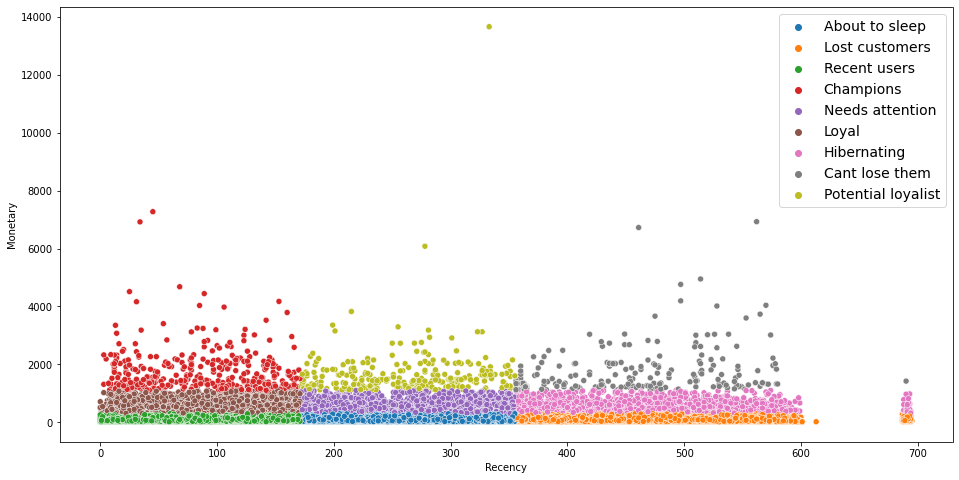

In [152]:
plt.figure(figsize = (16, 8))

sns.scatterplot(x = 'Recency', y = 'Monetary', hue = 'Segmentation', data = df_customers)
plt.legend(fontsize = 14)

So, this graph makes our segments very clear. Here, we see that champions often show a higher monetary value and a lower recency. At the opposite spectrum, lost customers show a very high recency, and a very low monetary value.

# Final recommendations

In this project, we perform the RFM analysis to segmentate our customers. Here, we used a dataset from OLIST to separate our customers based on Recency, Frequency, and Monetary. For Recency, we evaluated how many days have passed since each customer's last purchase. For Frequency, we tried to obtain the number of orders for each customer. However, we soon noticed that, in our dataset, all customers only had 1 order. Thus, we could not work with frequency. Then, for Monetary, we evaluated the amount of money spent by each customer. 

Finally, we performed our customer segmentation based on Frequency and Monetary. Thus, we defined 9 classes in total, based on their clusters. As a recommendation, our company could make marketing campaigns for each segment:

* Lost customers: Long time since they last bought, and they spent very little. Not worth to touch on them.
* Hibernating/About to sleep: A low-cost marketing campaign can be run just to remind these customers that our company is here for them.
* Needs attention/Recent users: May be the target of a larger marketing campaign involving products of interest to these customers.
* Can't lose them: We could do a more structured marketing campaign, using promotional codes to make these customers come back to our company.
* Potential loyalist/Loyal: Use of "loyalty cards" to make these customers shop more often in our store. These "loyalty cards" could unlock different benefits based on the frequency, such as promotional codes and prizes.
* Champions: Deserve a marketing campaign that makes them gain a sense of belonging to the brand, making these customers even more loyal.

By applying a targeted campaign to each segment, we were able to make marketing more efficient and effective for each audience.